In [1]:
# Установим необходимые библиотеки
!pip install optuna --quiet
!pip install dython --quiet
!pip install shap --quiet
!pip install catboost --quiet

In [2]:
!pip install jinja2 --upgrade --quiet

In [3]:
# Настроим окружение
import numpy as np
import pandas as pd
import scipy.stats as st
import shap

import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from optuna.integration import OptunaSearchCV

from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, \
roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier

from dython import nominal
from datetime import datetime

In [4]:
# Зададим распределения оптюны и отключим предупреждения
opt_distr_int = optuna.distributions.IntDistribution
opt_distr_float = optuna.distributions.FloatDistribution
opt_distr_cat = optuna.distributions.CategoricalDistribution
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [5]:
# Настроим параметры отображения графиков
plt.style.use("seaborn-v0_8")
shap.initjs()

In [6]:
# Настроим параметры отображения в pandas
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 0)

## Изучение исходных данных

Имеются данные об обращении застрахованных по ДМС в лечебные учреждения за 2021 год и январь 2022-го года с указанием даты обращения, количества полученных медицинских услуг и их суммарной стоимости. Также доступна информация о поле и возрасте пациентов. 

Задача - обучить модель предсказания факта обращения застрахованного в феврале 2022. Т.е., требуется классифицировать застрахованных на 2 класса: 1 - застрахованный обратится в феврале 2022 года, 0 - застрахованный не обратится в феврале 22 года

Обобщим задачу - построим модель машинного обучения, предсказывающую, обратится ли застрахованный в следующем месяце.

In [7]:
data = pd.read_csv(
    '/content/drive/MyDrive/datasets/test_assignments/mainslab/MainsLab_data_DS_22.csv',
    parse_dates=[1])

In [8]:
display(data)
data.info()

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount
0,125045,2021-03-03,1.0,6,2.0,2260.00
1,125045,2021-04-11,1.0,6,1.0,1600.00
2,125045,2021-04-18,1.0,6,5.0,4510.00
3,125045,2021-04-23,1.0,6,1.0,380.00
4,125045,2021-06-09,1.0,6,1.0,2500.00
...,...,...,...,...,...,...
764328,1226064,2022-01-13,2.0,29,1.0,950.00
764329,1226064,2022-01-25,2.0,29,5.0,1501.00
764330,1226064,2022-01-26,2.0,29,2.0,427.50
764331,1226151,2022-01-10,2.0,58,1.0,950.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764333 entries, 0 to 764332
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   insured               764333 non-null  int64         
 1   service_date          764333 non-null  datetime64[ns]
 2   sex_id                764129 non-null  float64       
 3   age_for_service_date  764333 non-null  int64         
 4   serv_count            764333 non-null  float64       
 5   serv_amount           764333 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 35.0 MB


Согласно документации:

- insured - уникальный ид застрахованного лица
- service_date - дата оказания услуги
- service_count - количество оказанных услуг
- service_amount - суммарная цена оказанных услуг
- sex_id - пол застрахованного
- age_for_service_date - возраст застрахованного на дату оказания услуги

Заметим наличие явных пропусков в колонке sex_id. 

Типы столбцов выглядят верными.

## Исследование данных

### Предварительная обработка

#### Дубликаты

Проверим данные на дубликаты

In [9]:
data.duplicated().sum()

52

Рассмотрим поближе:

In [10]:
data[data.duplicated(keep=False)]

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount
13058,146008,2021-03-25,2.0,44,1.0,1500.0
13059,146008,2021-03-25,2.0,44,1.0,1500.0
32377,159039,2021-02-18,2.0,44,2.0,2160.0
32378,159039,2021-02-18,2.0,44,2.0,2160.0
63031,178089,2021-01-22,2.0,31,1.0,1600.0
...,...,...,...,...,...,...
754458,831153,2022-01-20,2.0,29,1.0,1200.0
754529,831178,2022-01-27,2.0,38,1.0,1200.0
754530,831178,2022-01-27,2.0,38,1.0,1200.0
754709,831238,2021-12-13,2.0,5,1.0,1425.0


Дубликаты являются явными, а потому их можно просто удалить

In [11]:
data = data.drop_duplicates()

#### Пропуски

Рассмотрим пропуски

In [12]:
data.isna().sum()

insured                   0
service_date              0
sex_id                  204
age_for_service_date      0
serv_count                0
serv_amount               0
dtype: int64

Заполним эти пропуски значениями по другой строке

In [13]:
data.loc[:,'sex_id'] = data.loc[:,'sex_id'].fillna(data.groupby('insured')['sex_id'].transform('first'))
data.isna().sum()

insured                   0
service_date              0
sex_id                  132
age_for_service_date      0
serv_count                0
serv_amount               0
dtype: int64

Оставшиеся строки с пропусками можно удалить, т.к. их весьма немного

In [14]:
print(
    'Процент удалённых значений: {:.3%}'
    .format(data.isna().sum()['sex_id'] / len(data))
    )
data = data.dropna()

Процент удалённых значений: 0.017%


### Распределение признаков в данных

In [15]:
# Выделим признаки:
numeric = data.drop(['sex_id', 'insured'], axis=1).columns
categorical = ['sex_id'] 

#### Категориальные признаки

In [16]:
# Определим функцию для отображения распределения категориальных признаков
def get_cat_barplot(data, column, size=(6,6)):

  values = data[column].value_counts().sort_index()

  fig, ax = plt.subplots(figsize=size)
  ax.bar(x=values.index, height=values)
  ax.set_xticks(values.index)
  ax.set_xticklabels( values.index.values)
  ax.set(
      xlabel=f'{column}', ylabel=f'Частота',
      title=f'Распределение признака {column}'
      )
  
  plt.show()

  result = pd.concat(
      [values,
      data[column].value_counts(normalize=True).sort_index()
      ], axis=1
      )
  
  result.columns = ['Количество', f'Распределение {column}']

  display(
      result.style.format(
          '{:.2%}'.format, 
          subset=f'Распределение {column}'
                  )
      )

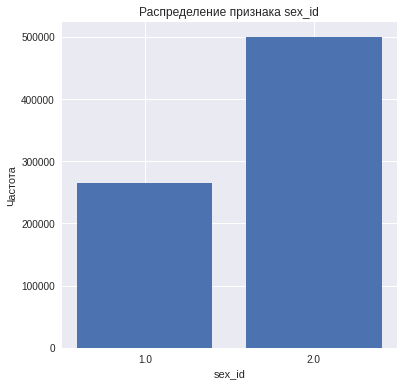

,Количество,Распределение sex_id
1.000000,264613,34.63%
2.000000,499536,65.37%


In [17]:
for col in categorical:
  get_cat_barplot(data, col)

Как можно видеть, один из полов в данных преобладает, но ощутимого дисбаланса нет

#### Количественные признаки

In [18]:
# Определим функцию для отображения распределений количественных признаков
def get_num_plot(data, column, size=(14,6)):

  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=size)

  sns.histplot(ax=ax1, data=data[column], bins='auto', kde=True)
  ax1.set_title(f'Гистограмма распределения {column}')
  try:
    sns.boxplot(ax=ax2, x=data[column])
    ax2.set_title(f'Диаграмма размаха {column}')
  except:
    pass

  plt.tight_layout()
  plt.show()
  print('\n')

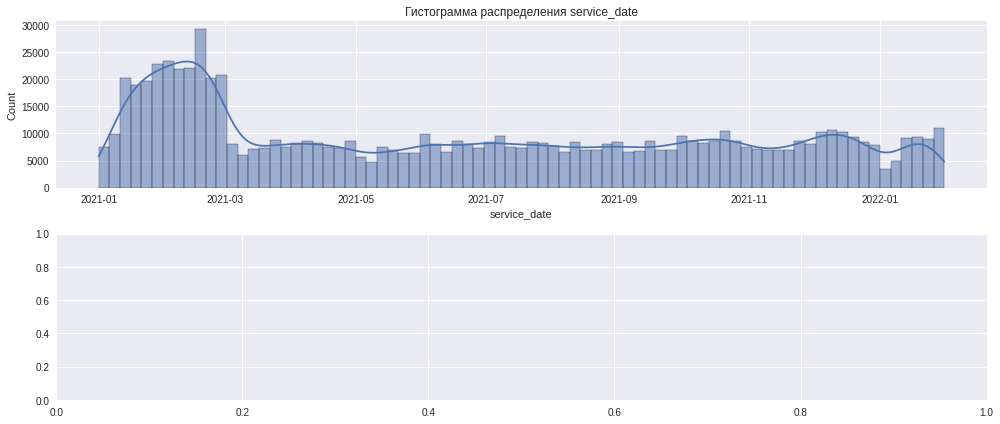

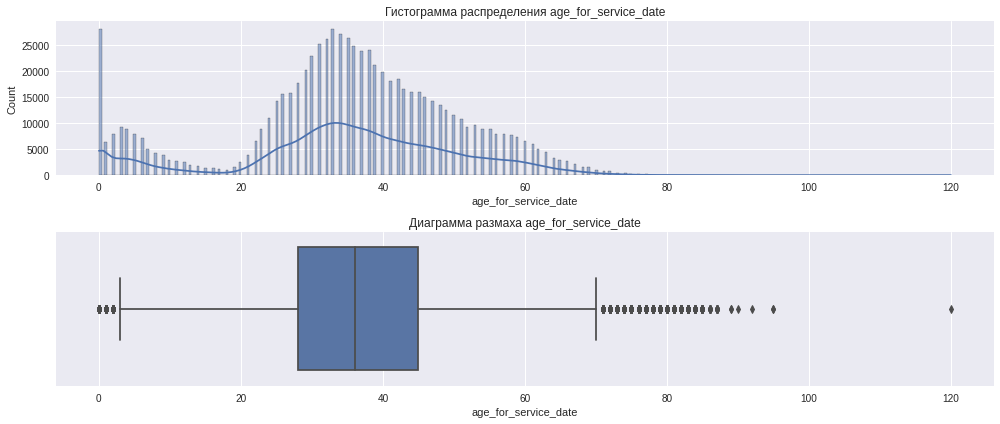

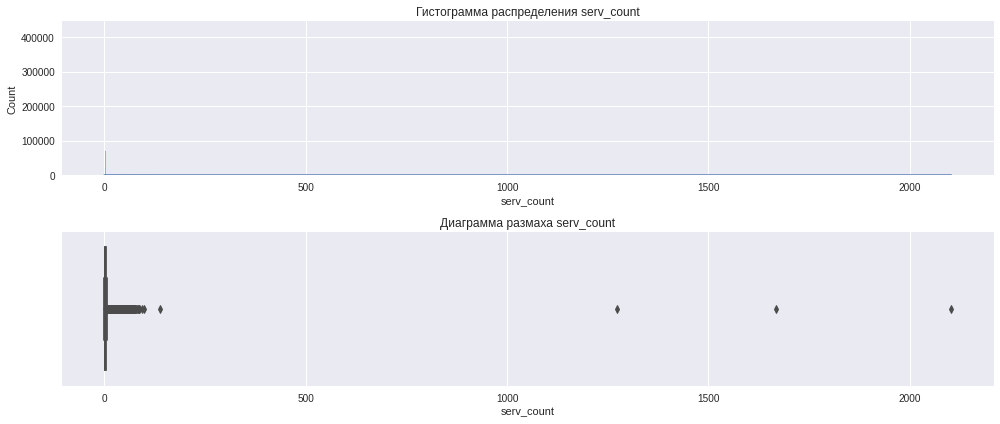

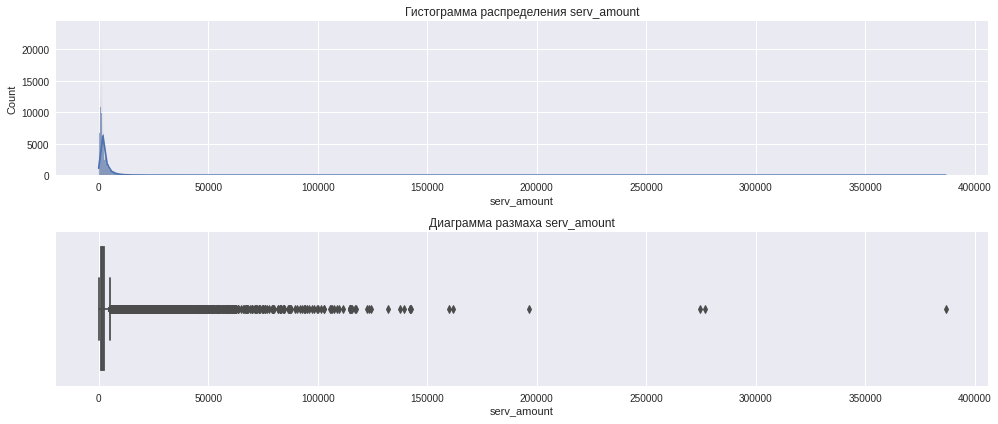

In [19]:
for col in numeric:
  get_num_plot(data, col)

Рассмотрим некоторые признаки в приближениях

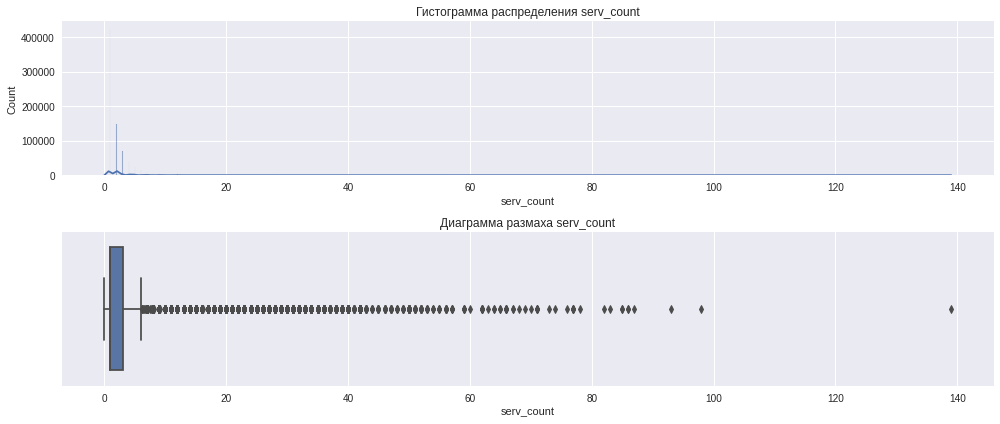

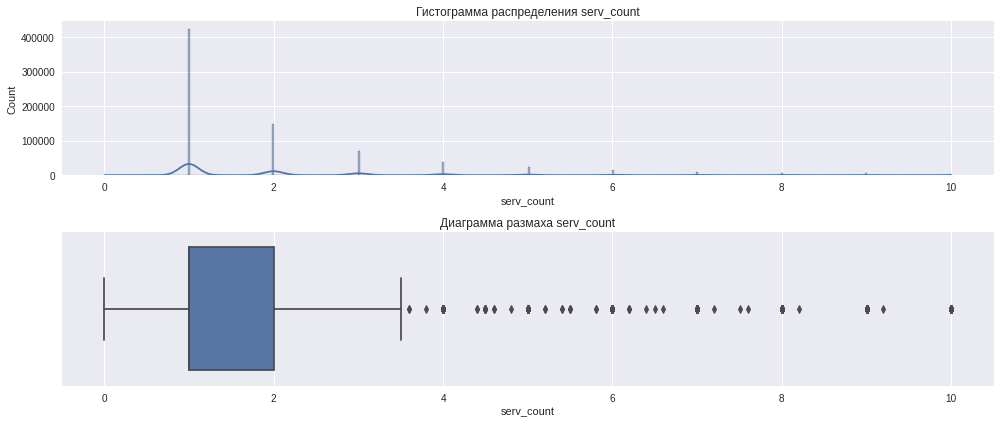

In [20]:
get_num_plot(data.query('serv_count <= 250'), 'serv_count')
get_num_plot(data.query('serv_count <= 10'), 'serv_count')

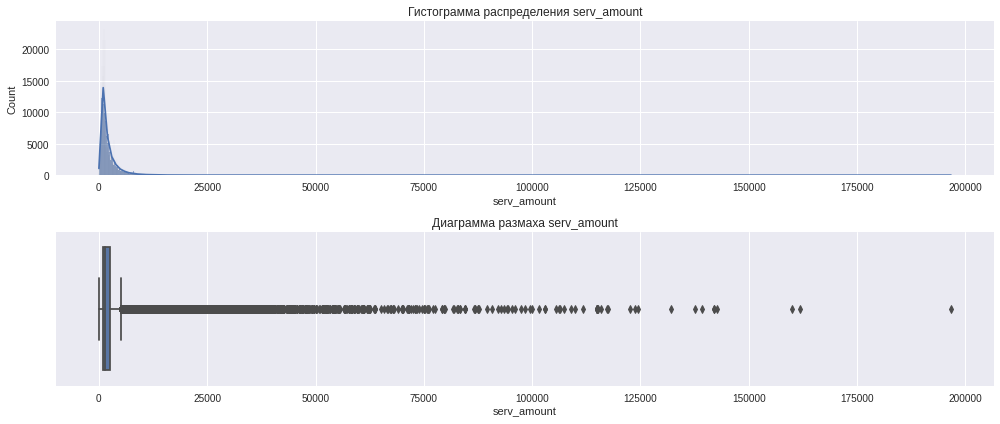

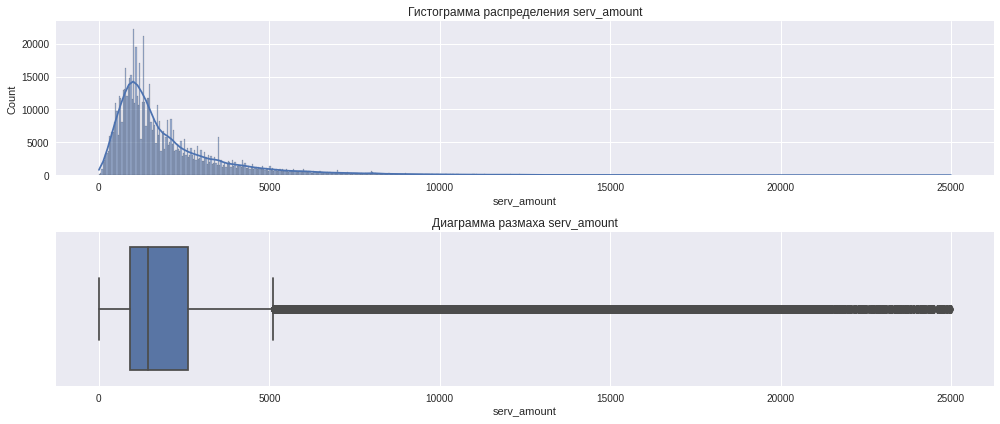

In [21]:
get_num_plot(data.query('serv_amount <= 200000'), 'serv_amount')
get_num_plot(data.query('serv_amount <= 25000'), 'serv_amount')

- Ошибочных/отрицательных данных в признаках нет
- Большинство количественных признаков имеют нессиметричное распределение с явным хвостом в правую сторону - в большинстве случаев это связано с наличием большого количества выбросов, некоторые из которых выглядят аномальными
- Данные выбросы необходимо будет обработать перед машинным обучением, а предпочтение отдать модели, устойчивой к ним.

### Обработка аномалий

Рассмотрим, есть ли расхождения в данных по полу у данных по одному застрахованному

In [22]:
temp = data.groupby('insured')['sex_id'].nunique()[lambda x: x>1]
temp

insured
211680    2
255618    2
Name: sex_id, dtype: int64

Таких значений всего два, их мы тоже можем удалить

In [23]:
data = data[~data['insured'].isin(temp)]

In [24]:
data.describe()

,insured,sex_id,age_for_service_date,serv_count,serv_amount
count,7.641490e+05,764149.000000,764149.000000,764149.000000,764149.000000
mean,4.730596e+05,1.653715,34.926840,2.360311,2242.935888
std,1.959506e+05,0.475786,16.035186,4.479647,2877.123820
min,1.250450e+05,1.000000,0.000000,0.000000,0.000000
25%,2.658720e+05,1.000000,28.000000,1.000000,921.000000
50%,5.167950e+05,2.000000,36.000000,1.000000,1450.000000
75%,6.284440e+05,2.000000,45.000000,3.000000,2610.000000
max,1.226151e+06,2.000000,120.000000,2103.000000,386800.000000


Рассмотрим нулевые значения в колонках serv_count

In [25]:
data[data['serv_count']==0]

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount
153771,235243,2021-04-10,2.0,37,0.0,855.0
167522,244392,2021-04-30,2.0,29,0.0,855.0


Таких значений всего два. Видится безопасным заменить нулевые значения на единицу, поскольку по сумме оказанные услуги невелики

In [26]:
data['serv_count'] = data['serv_count'].replace(0,1)

Рассмотрим аномально большие значения в признаках serv_count и serv_amount

In [27]:
data[data['serv_count'] > 500]

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount
285649,410592,2021-02-03,2.0,33,1274.0,2860.0
400615,531085,2021-01-29,2.0,40,1667.0,970.0
746940,819423,2021-12-14,1.0,25,2103.0,26234.0


In [28]:
data[data['serv_amount'] > 150000]

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount
53927,172602,2021-02-18,2.0,42,7.0,160070.96
60170,176296,2021-01-08,1.0,62,2.0,276962.73
60195,176296,2021-02-12,1.0,62,3.0,274593.26
351879,501588,2021-01-22,2.0,24,20.0,386800.00
508822,571534,2021-10-05,1.0,22,22.0,196699.50
657420,689654,2021-09-07,1.0,58,22.0,161802.00


Из графиков было видно, что большое количество данных выпадают за пределы нормальных значений.

Были проведены следующие тесты по обработке выбросов:

- Удаление выбросов от 3-5х стандартных отклонений от медианы
- Усечение по межквартильному размаху (1,5-3,5 IQR)
- Удаление признаков, слабо коррелирующих с целевым

По результатам прогонов в разных конфигурациях, которые не показали рост метрик по сравнению с необработанными выбросами в данных, было принято решение, что лучше всего их оставить как без обработки за исключением явных аномалий.

In [29]:
# Удалим аномальные отклонения в данных
len_data_old = len(data)

data = data[data['serv_count'] < 500]
data = data[data['serv_amount'] < 150000]
data = data[data['age_for_service_date'] < 100]

print(f'Доля удалённых значений: {len_data_old/len(data)-1:.3%}')

Доля удалённых значений: 0.001%


### Feature Engineering

#### Формирование целевого признака

Используя данные за год, выберем обращения в декабре 2021-го года как целевой признак - месяц, в котором застрахованный обратится/не обратится за помощью.

In [30]:
# Сформируем целевой признак за декабрь
data['applied'] = np.where(
    data['service_date']
    .between('2021-12-01','2021-12-31')
    , 1, 0
    )

data['applied'] = data.groupby('insured')['applied'].transform('max')

Удалим данные за декабрь, чтобы избежать утечки целевого признака

In [31]:
data = data[data['service_date'] < '2021-12-01']

#### Добавление фич

Определим функцию, добавляющую признаки до формирования датасета

In [32]:
def make_features(data):
  df = data.copy()
  df = df.sort_values(by='service_date')

  # Добавим признак количества обращений застрахованного
  df['referral_count'] = df.groupby('insured')['service_date'].transform('count')

  # Добавим признак количества дней с предыдущего обращения за помощью
  df['days_inactive'] = df.groupby('insured')['service_date'].transform('last')
  df['days_inactive'] = (datetime.strptime('2021-12-01', '%Y-%m-%d') - df['days_inactive']).dt.days

  # Добавим признак среднего времени в году для обращения за помощью
  df['seasonal'] = df['service_date'].dt.dayofyear
  df['seasonal'] = df.groupby('insured')['seasonal'].transform('mean').round()

  # Добавим признак частоты посещений
  df['visit_frequency'] = (
      (
      df.groupby('insured')['service_date'].transform('last') -
      df.groupby('insured')['service_date'].transform('first')
      ).dt.days / df['serv_count']
      ).round(2)

  return df

In [33]:
data

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount,applied
0,125045,2021-03-03,1.0,6,2.0,2260.0,0
1,125045,2021-04-11,1.0,6,1.0,1600.0,0
2,125045,2021-04-18,1.0,6,5.0,4510.0,0
3,125045,2021-04-23,1.0,6,1.0,380.0,0
4,125045,2021-06-09,1.0,6,1.0,2500.0,0
...,...,...,...,...,...,...,...
763785,866147,2021-11-13,2.0,35,2.0,2220.0,0
763790,866298,2021-03-21,1.0,23,1.0,1450.0,1
764263,930770,2021-03-28,2.0,56,4.0,1538.5,0
764277,940712,2021-11-23,1.0,35,1.0,1200.0,0


In [34]:
data = make_features(data)
data

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount,applied,referral_count,days_inactive,seasonal,visit_frequency
396602,530314,2021-01-01,1.0,1,4.0,4780.0,0,2,329,4.0,1.25
85939,195930,2021-01-01,2.0,39,3.0,4100.0,0,7,264,39.0,23.33
396486,530304,2021-01-01,2.0,45,1.0,1635.9,0,16,182,43.0,152.00
49361,169006,2021-01-01,2.0,26,1.0,2100.0,0,1,334,1.0,0.00
149851,231798,2021-01-01,1.0,28,6.0,8581.5,0,3,278,35.0,9.33
...,...,...,...,...,...,...,...,...,...,...,...
702140,730256,2021-11-30,2.0,45,4.0,6740.0,0,3,1,300.0,13.50
702075,729741,2021-11-30,1.0,23,1.0,2550.0,0,9,1,309.0,60.00
336481,490986,2021-11-30,1.0,48,6.0,12070.0,1,3,1,141.0,48.33
525363,586571,2021-11-30,1.0,31,4.0,3570.0,1,15,1,321.0,24.25


Сформируем датасет для обучения

In [35]:
def transform_data(data):
  df = data.copy()

  serv_count = df.groupby('insured')['serv_count'].sum()
  serv_amount = df.groupby('insured')['serv_amount'].sum()

  df = data.groupby('insured').max().drop('service_date', axis=1)
  df['serv_count'] = serv_count
  df['serv_amount'] = serv_amount

  # Добавим признак средней цены за оказанную услугу
  df['serv_price_mean'] = (df['serv_amount'] / df['serv_count']).round(2)

  return df

In [36]:
df = transform_data(data)
df

,sex_id,age_for_service_date,serv_count,serv_amount,applied,referral_count,days_inactive,seasonal,visit_frequency,serv_price_mean
insured,,,,,,,,,,
125045,1.0,7,12.0,15350.00,0,6,7,145.0,266.0,1279.17
125046,2.0,29,41.0,42240.00,1,10,4,269.0,165.0,1030.24
125047,2.0,53,8.0,7060.00,0,1,181,154.0,0.0,882.50
125048,1.0,18,100.0,121280.00,1,28,15,204.0,288.0,1212.80
125049,1.0,1,21.0,20301.92,0,6,307,23.0,11.0,966.76
...,...,...,...,...,...,...,...,...,...,...
866145,1.0,18,1.0,1450.00,0,1,25,310.0,0.0,1450.00
866147,2.0,35,2.0,2220.00,0,1,18,317.0,0.0,1110.00
866298,1.0,23,1.0,1450.00,1,1,255,80.0,0.0,1450.00


Получили датасет со следующими признаками:

- insured - уникальный ид застрахованного лица
- serv_count - количество оказанных услуг за всё время
- serv_amount - суммарная цена оказанных услуг за всё время
- sex_id - пол застрахованного
- age_for_service_date - возраст застрахованного на дату оказания последней услуги
- referral_count - количество обращений в медицинские учреждения за год
- days_inactive - количество дней с последнего обращения
- seasonal - среднее время в году обращения за помощью

### Баланс классов в целевых признаках

In [37]:
# Определим функцию для отображения распределения целевых признаков
def get_target_barplot(data, column, size=(6,4)):

  values = data[column].value_counts().sort_index()
  fig, ax = plt.subplots(figsize=size)

  sns.barplot(ax=ax, x=values.index, y=values)
  ax.set(
      xlabel=f'{column}', ylabel=f'Частота',
      title=f'Распределение целевого признака {column}'
      )
  
  plt.tight_layout()
  plt.show()

  result = pd.concat(
      [values,
       data[column].value_counts(normalize=True).sort_index()
       ], axis=1)
  result.columns = ['Количество наблюдений', f'Доля класса {column}']

  display(
      result.style.format(
          '{:.2%}'.format, subset=[f'Доля класса {column}']
          ))

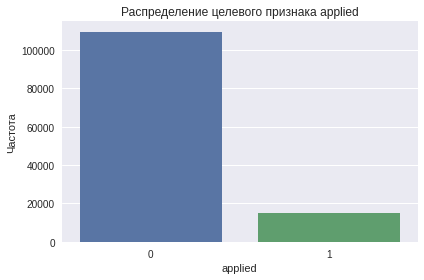

,Количество наблюдений,Доля класса applied
0,109453,88.09%
1,14804,11.91%


In [38]:
get_target_barplot(df, 'applied')

Заметен сильный дисбаланс в целевом признаке - это необходимо учесть при обучении, при этом предпочтение стоит отдать деревянным моделям

## Подготовка данных

### Исследование взаимосвязей

In [39]:
# Определим признаки в новом датафрейме
numeric = df.drop(['sex_id', 'applied'], axis=1).columns
categorical = ['sex_id']

Мы можем оценить влияние категориальных признаков на целевой с помощью Коэффициента Крамера - мере связи двух номинальных переменных на основе критерия Хи-квадрат

In [40]:
arr = []

for col in categorical:
  arr.append(nominal.cramers_v(df[col], df['applied']))

arr = pd.DataFrame(
      arr, 
      columns=["Cramer's V"],
      index=categorical
      ).sort_values(
          by="Cramer's V",
          ascending=False)

display(arr)

,Cramer's V
sex_id,0.033147


Для количественных признаков мы можем оценить корреляцию между ними и бинарным целевым признаком с помощью коэффициента точечной бисериальной корреляции

In [41]:
arr = []

for col in numeric:
  arr.append(st.pointbiserialr(df[col], df['applied'])[0])  

arr = pd.DataFrame(
      arr, 
      columns=['Point biserial correlation'],
      index=numeric
      ).sort_values(
          by='Point biserial correlation',
          ascending=False)
      
display(arr)

,Point biserial correlation
seasonal,0.310473
visit_frequency,0.229318
referral_count,0.191873
serv_count,0.133815
serv_amount,0.127704
serv_price_mean,-0.023758
age_for_service_date,-0.051416
days_inactive,-0.360156


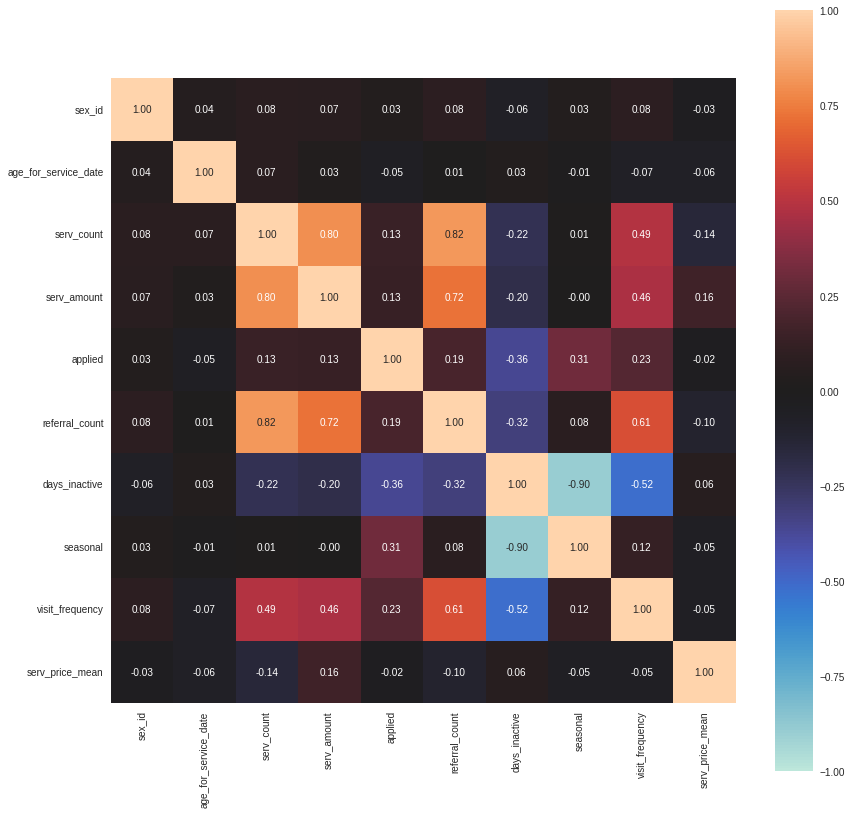

In [42]:
nominal.associations(df, figsize=(14,14))
plt.show()

Большинство признаков имеют очень слабую корреляцию с целевым признаком - моделям машинного обучения будет трудно установить явные связи.

Наиболее значимыми являются признаки среднего времени в году обращения за помощью, количество дней с предыдущего обращения и количество таких обращений.

### Составление выборок

Сформируем датасет для валидации. За целевой признак возьмём факт обращения застрахованного в январе

In [43]:
data_valid = pd.read_csv(
    '/content/drive/MyDrive/datasets/test_assignments/mainslab/MainsLab_data_DS_22.csv',
    parse_dates=[1])

In [44]:
# Сформируем целевой признак за январь
data_valid['applied'] = np.where(
    data_valid['service_date']
    .between('2022-01-01','2022-01-31')
    , 1, 0
    )

data_valid['applied'] = data_valid.groupby('insured')['applied'].transform('max')

data_valid = data_valid[data_valid['service_date'] < '2022-01-01']

In [45]:
# Обработаем аномалии и удалим пропуски
len_data_valid_old = len(data_valid)

data_valid = data_valid.drop_duplicates()

data_valid.loc[:,'sex_id'] = data_valid.loc[:,'sex_id'].fillna(data_valid.groupby('insured')['sex_id'].transform('first'))
data_valid = data_valid.dropna()

data_valid['serv_count'] = data_valid['serv_count'].replace(0,1)

temp = data_valid.groupby('insured')['sex_id'].nunique()[lambda x: x>1]
data_valid = data_valid[~data_valid['insured'].isin(temp)]

data_valid = data_valid[data_valid['serv_count'] < 500]
data_valid = data_valid[data_valid['serv_amount'] < 150000]
data_valid = data_valid[data_valid['age_for_service_date'] < 100]

print(f'Доля обработанных значений: {len_data_valid_old/len(data_valid)-1:.3%}')

Доля обработанных значений: 0.026%


In [46]:
# Добавим признаки и сформируем датасет
data_valid = make_features(data_valid)
df_valid = transform_data(data_valid)

In [47]:
X_train = df.drop(['applied'], axis=1)
X_valid = df_valid.drop(['applied'], axis=1)

y_train = df['applied']
y_valid = df_valid['applied']

## Обучение

Мы будем использовать модели со встроенной кросс-валидацией, или использовать optuna для поиска гиперпараметров через кросс-валидацию, а потому разбивать тренировочную выборку смысла нет.

In [48]:
# Зададим сетку гиперпараметров для подбора

params_cat = {
    'iterations':opt_distr_int(100,500),
    'learning_rate':opt_distr_float(0.01,1.0),
    'depth':opt_distr_int(2,10)
    }

params_lgb = {
    'n_estimators':opt_distr_int(100,500),
    'learning_rate':opt_distr_float(0.01,1.0),
    'max_depth':opt_distr_int(2,10)
    }

params_tree = {
    'min_samples_leaf':opt_distr_int(2,15),
    'min_samples_split':opt_distr_int(2,15),
    'max_depth':opt_distr_int(2,25),
    'criterion':opt_distr_cat(['gini', 'entropy'])
    }

params_forest= {
    'n_estimators':opt_distr_int(50,150),
    'min_samples_leaf':opt_distr_int(2,15),
    'min_samples_split':opt_distr_int(2,15),
    'max_depth':opt_distr_int(2,10),
    'criterion':opt_distr_cat(['gini', 'entropy'])
    }

### Логистическая регрессия

In [49]:
# Отмасштабируем данные для линейной модели
scaler = StandardScaler()
X_train_lr = X_train.copy()
X_valid_lr = X_valid.copy()

X_train_lr[numeric] = scaler.fit_transform(X_train_lr[numeric])
X_valid_lr[numeric] = scaler.transform(X_valid_lr[numeric])

In [51]:
logreg_model = LogisticRegressionCV(
    scoring='roc_auc', random_state=777, class_weight='balanced')

logreg_model.fit(X_train_lr, y_train)

predictions_logreg = logreg_model.predict(X_valid_lr)
predictions_proba_logreg = logreg_model.predict_proba(X_valid_lr)[:,1]
accuracy_logreg = accuracy_score(y_valid, predictions_logreg)
roc_auc_logreg = roc_auc_score(y_valid, predictions_proba_logreg)

precision_logreg, recall_logreg, f1_score_logreg = (
    precision_recall_fscore_support(y_valid, predictions_logreg)[:3]
    )

print(f'Accuracy модели Логистической регрессии: {accuracy_logreg:.3f}')
print(f'Precision модели Логистической регрессии: {precision_logreg[1]:.3f}')
print(f'Recall модели Логистической регрессии: {recall_logreg[1]:.3f}')
print(f'F1-score модели Логистической регрессии: {f1_score_logreg[1]:.3f}')
print(f'ROC-AUC модели Логистической регрессии: {roc_auc_logreg:.3f}')

Accuracy модели Логистической регрессии: 0.644
Precision модели Логистической регрессии: 0.191
Recall модели Логистической регрессии: 0.882
F1-score модели Логистической регрессии: 0.315
ROC-AUC модели Логистической регрессии: 0.833


### Дерево решений

In [52]:
# Найдём лучшие гиперпараметры через кросс-валидацию optuna

tree_model = DecisionTreeClassifier(random_state=777, class_weight='balanced')

optuna_tree = OptunaSearchCV(
    tree_model, params_tree, n_trials=20,
    random_state=777, scoring='roc_auc')

optuna_tree.fit(X_train, y_train)

tree_model = optuna_tree.best_estimator_

print(f'Лучшие параметры Дерева решений: {optuna_tree.best_params_}')

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.


Лучшие параметры Дерева решений: {'min_samples_leaf': 9, 'min_samples_split': 2, 'max_depth': 2, 'criterion': 'entropy'}


In [53]:
tree_model.fit(X_train, y_train)

predictions_tree = tree_model.predict(X_valid)
predictions_proba_tree = tree_model.predict_proba(X_valid)[:,1]

accuracy_tree = accuracy_score(y_valid, predictions_tree)
roc_auc_tree = roc_auc_score(y_valid, predictions_proba_tree)
precision_tree, recall_tree, f1_score_tree = (
    precision_recall_fscore_support(y_valid, predictions_tree)[:3]
    )

print(f'Accuracy модели Дерева решений: {accuracy_tree:.3f}')
print(f'Precision модели Дерева решений: {precision_tree[1]:.3f}')
print(f'Recall модели Дерева решений: {recall_tree[1]:.3f}')
print(f'F1-score модели Дерева решений: {f1_score_tree[1]:.3f}')
print(f'ROC-AUC модели Дерева решений: {roc_auc_tree:.3f}')

Accuracy модели Дерева решений: 0.609
Precision модели Дерева решений: 0.180
Recall модели Дерева решений: 0.908
F1-score модели Дерева решений: 0.301
ROC-AUC модели Дерева решений: 0.809


### LightGBM

In [54]:
%%time
# Найдём лучшие гиперпараметры через кросс-валидацию optuna

lgb_model = LGBMClassifier(
    random_state=777,
    class_weight='balanced')

optuna_lgb = OptunaSearchCV(
    lgb_model, params_lgb, n_trials=20,
    random_state=777, scoring='roc_auc')

optuna_lgb.fit(X_train, y_train)

lgb_model = optuna_lgb.best_estimator_

print(f'Лучшие параметры LGBMClassifier: {optuna_lgb.best_params_}')

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.


Лучшие параметры LGBMClassifier: {'n_estimators': 102, 'learning_rate': 0.036351577551102666, 'max_depth': 2}
CPU times: user 4min 11s, sys: 1.54 s, total: 4min 13s
Wall time: 4min 19s


In [55]:
lgb_model.fit(X_train, y_train)

predictions_lgb = lgb_model.predict(X_valid)
predictions_proba_lgb = lgb_model.predict_proba(X_valid)[:,1]

accuracy_lgb = accuracy_score(y_valid, predictions_lgb)
roc_auc_lgb = roc_auc_score(y_valid, predictions_proba_lgb)
precision_lgb, recall_lgb, f1_score_lgb = (
    precision_recall_fscore_support(y_valid, predictions_lgb)[:3]
    )

print(f'Accuracy модели LightGBMClassifier: {accuracy_lgb:.3f}')
print(f'Precision модели LightGBMClassifier: {precision_lgb[1]:.3f}')
print(f'Recall модели LightGBMClassifier: {recall_lgb[1]:.3f}')
print(f'F1-score модели LightGBMClassifier: {f1_score_lgb[1]:.3f}')
print(f'ROC-AUC модели LightGBMClassifier: {roc_auc_lgb:.3f}')

Accuracy модели LightGBMClassifier: 0.677
Precision модели LightGBMClassifier: 0.203
Recall модели LightGBMClassifier: 0.850
F1-score модели LightGBMClassifier: 0.327
ROC-AUC модели LightGBMClassifier: 0.829


### Случайный лес

In [56]:
%%time
# Найдём лучшие гиперпараметры через кросс-валидацию optuna

forest_model = RandomForestClassifier(random_state=777, class_weight='balanced')

optuna_forest = OptunaSearchCV(
    forest_model, params_forest, n_trials=20,
    random_state=777, scoring='roc_auc')

optuna_forest.fit(X_train, y_train)

forest_model = optuna_forest.best_estimator_

print(f'Лучшие параметры Случайного леса: {optuna_forest.best_params_}')

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.


Лучшие параметры Случайного леса: {'n_estimators': 114, 'min_samples_leaf': 4, 'min_samples_split': 11, 'max_depth': 4, 'criterion': 'entropy'}
CPU times: user 14min 28s, sys: 5.09 s, total: 14min 33s
Wall time: 14min 38s


In [57]:
forest_model.fit(X_train, y_train)

predictions_forest = forest_model.predict(X_valid)
predictions_proba_forest = forest_model.predict_proba(X_valid)[:,1]

accuracy_forest = accuracy_score(y_valid, predictions_forest)
roc_auc_forest = roc_auc_score(y_valid, predictions_proba_forest)
precision_forest, recall_forest, f1_score_forest = (
    precision_recall_fscore_support(y_valid, predictions_forest)[:3]
    )

print(f'Accuracy модели Случайного леса: {accuracy_forest:.3f}')
print(f'Precision модели Случайного леса: {precision_forest[1]:.3f}')
print(f'Recall модели Случайного леса: {recall_forest[1]:.3f}')
print(f'F1-score модели Случайного леса: {f1_score_forest[1]:.3f}')
print(f'ROC-AUC модели Случайного леса: {roc_auc_forest:.3f}')

Accuracy модели Случайного леса: 0.627
Precision модели Случайного леса: 0.186
Recall модели Случайного леса: 0.894
F1-score модели Случайного леса: 0.308
ROC-AUC модели Случайного леса: 0.829


### CatBoost

In [58]:
%%time
# Найдём лучшие гиперпараметры через кросс-валидацию optuna

cat_model = CatBoostClassifier(
    random_state=777,
    auto_class_weights='Balanced',
    verbose=0)

optuna_cat = OptunaSearchCV(
    cat_model, params_cat, n_trials=20,
    random_state=777, scoring='roc_auc')

optuna_cat.fit(X_train, y_train)

cat_model = optuna_cat.best_estimator_

print(f'Лучшие параметры CatBoostClassifier: {optuna_cat.best_params_}')

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.


Лучшие параметры CatBoostClassifier: {'iterations': 102, 'learning_rate': 0.036351577551102666, 'depth': 2}
CPU times: user 19min 9s, sys: 34.6 s, total: 19min 43s
Wall time: 10min 42s


In [59]:
cat_model.fit(X_train, y_train)

predictions_cat = cat_model.predict(X_valid)
predictions_proba_cat = cat_model.predict_proba(X_valid)[:,1]

accuracy_cat = accuracy_score(y_valid, predictions_cat)
roc_auc_cat = roc_auc_score(y_valid, predictions_proba_cat)
precision_cat, recall_cat, f1_score_cat = (
    precision_recall_fscore_support(y_valid, predictions_cat)[:3]
    )

print(f'Accuracy модели CatBoostClassifier: {accuracy_cat:.3f}')
print(f'Precision модели CatBoostClassifier: {precision_cat[1]:.3f}')
print(f'Recall модели CatBoostClassifier: {recall_cat[1]:.3f}')
print(f'F1-score модели CatBoostClassifier: {f1_score_cat[1]:.3f}')
print(f'ROC-AUC модели CatBoostClassifier: {roc_auc_cat:.3f}')

Accuracy модели CatBoostClassifier: 0.670
Precision модели CatBoostClassifier: 0.201
Recall модели CatBoostClassifier: 0.859
F1-score модели CatBoostClassifier: 0.325
ROC-AUC модели CatBoostClassifier: 0.828


## Отбор модели

Обучим модели на всех данных и получим финальные метрики

### Метрики

Составим таблицу полученных показателей моделей

In [60]:
chars_logreg = [ 
    accuracy_logreg, precision_logreg[1], recall_logreg[1],
    f1_score_logreg[1], roc_auc_logreg
    ]

chars_tree = [
    accuracy_tree, precision_tree[1], recall_tree[1], 
    f1_score_tree[1], roc_auc_tree
    ]

chars_forest = [ 
    accuracy_forest, precision_forest[1], recall_forest[1], 
    f1_score_forest[1], roc_auc_forest
    ]    

chars_lgb = [
    accuracy_lgb, precision_lgb[1], recall_lgb[1], 
    f1_score_lgb[1], roc_auc_lgb
    ]    

chars_cat = [
    accuracy_cat, precision_cat[1], recall_cat[1], 
    f1_score_cat[1], roc_auc_cat
    ]    

In [61]:
models_table = pd.DataFrame(
    data=[chars_logreg, chars_tree, chars_forest, chars_cat, chars_lgb],
    columns=['Accuracy', 'Precision', 'Recall','F1 Score', 'ROC_AUC'],
    index=[
        'Логистическая регрессия', 'Дерево решений', 
        'Случайный лес', 'CatBoostClassifier','LightGBMClassifier'
        ]
        )

display(
    models_table.style.format(
        '{:.3f}'.format)
    )

,Accuracy,Precision,Recall,F1 Score,ROC_AUC
Логистическая регрессия,0.644,0.191,0.882,0.315,0.833
Дерево решений,0.609,0.180,0.908,0.301,0.809
Случайный лес,0.627,0.186,0.894,0.308,0.829
CatBoostClassifier,0.670,0.201,0.859,0.325,0.828
LightGBMClassifier,0.677,0.203,0.850,0.327,0.829


### Проверка на адекватность

In [62]:
for strat in ['most_frequent', 'prior', 'stratified', 'uniform']:
    model = DummyClassifier(strategy=strat, random_state=777)
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    predictions_proba = model.predict_proba(X_valid)[:,1]
    accuracy = accuracy_score(y_valid, predictions)
    roc_auc = roc_auc_score(y_valid, predictions_proba)
    precision, recall, f1_score = (
    precision_recall_fscore_support(y_valid, predictions, zero_division=0)[:3]
    )
    
    print(f'Accuracy пустышки при стратегии {strat}: {accuracy:.3f}')
    print(f'Precision пустышки при стратегии {strat}: {precision[1]:.3f}')
    print(f'Recall пустышки при стратегии {strat}: {recall[1]:.3f}')
    print(f'F1-score пустышки при стратегии {strat}: {f1_score[1]:.3f}')
    print(f'ROC-AUC пустышки при стратегии {strat}: {roc_auc:.3f}\n')

Accuracy пустышки при стратегии most_frequent: 0.907
Precision пустышки при стратегии most_frequent: 0.000
Recall пустышки при стратегии most_frequent: 0.000
F1-score пустышки при стратегии most_frequent: 0.000
ROC-AUC пустышки при стратегии most_frequent: 0.500

Accuracy пустышки при стратегии prior: 0.907
Precision пустышки при стратегии prior: 0.000
Recall пустышки при стратегии prior: 0.000
F1-score пустышки при стратегии prior: 0.000
ROC-AUC пустышки при стратегии prior: 0.500

Accuracy пустышки при стратегии stratified: 0.811
Precision пустышки при стратегии stratified: 0.095
Recall пустышки при стратегии stratified: 0.122
F1-score пустышки при стратегии stratified: 0.107
ROC-AUC пустышки при стратегии stratified: 0.502

Accuracy пустышки при стратегии uniform: 0.499
Precision пустышки при стратегии uniform: 0.092
Recall пустышки при стратегии uniform: 0.498
F1-score пустышки при стратегии uniform: 0.156
ROC-AUC пустышки при стратегии uniform: 0.500



Модели проходят проверку на адекватность - их показатели выше, чем у моделей пустышек

### Матрица ошибок

In [63]:
plt.style.use('default')

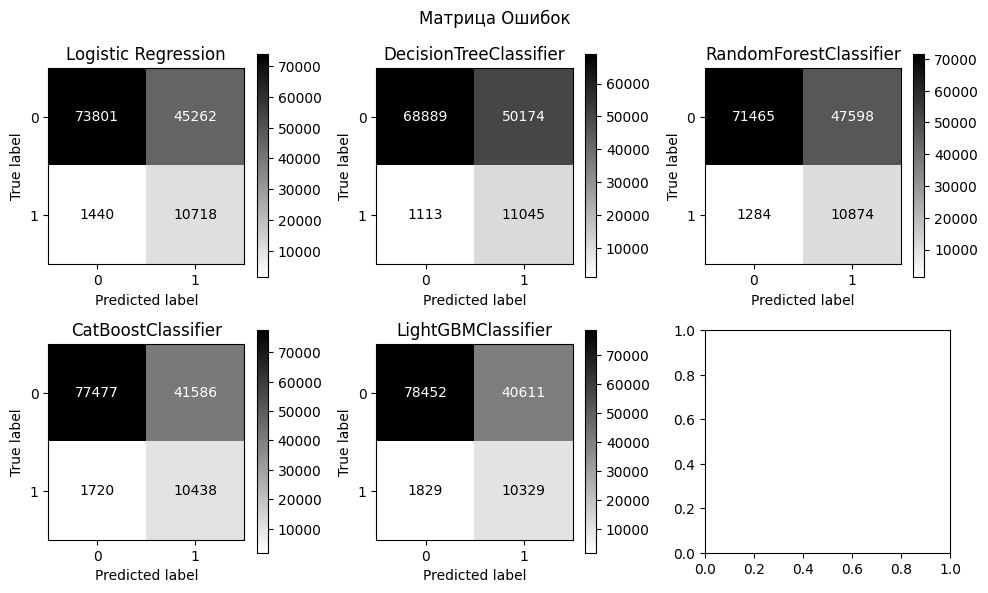

In [64]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
fig.suptitle('Матрица Ошибок')

logreg_matrix = ConfusionMatrixDisplay.from_predictions(
    y_valid, predictions_logreg,
    cmap='binary', ax=ax1[0],
    values_format='.0f')
logreg_matrix.ax_.set_title('Logistic Regression')

tree_matrix = ConfusionMatrixDisplay.from_predictions(
    y_valid, predictions_tree,
    cmap='binary', ax=ax1[1],
    values_format='.0f')
tree_matrix.ax_.set_title('DecisionTreeClassifier')

forest_matrix = ConfusionMatrixDisplay.from_predictions(
    y_valid, predictions_forest,
    cmap='binary', ax=ax1[2],
    values_format='.0f')
forest_matrix.ax_.set_title('RandomForestClassifier')

cat_matrix = ConfusionMatrixDisplay.from_predictions(
    y_valid, predictions_cat,
    cmap='binary', ax=ax2[0],
    values_format='.0f')
cat_matrix.ax_.set_title('CatBoostClassifier')

lgb_matrix = ConfusionMatrixDisplay.from_predictions(
    y_valid, predictions_lgb,
    cmap='binary', ax=ax2[1],
    values_format='.0f')
lgb_matrix.ax_.set_title('LightGBMClassifier')

plt.tight_layout()
plt.show()

In [65]:
display(models_table.style.format('{:.3f}'.format))

,Accuracy,Precision,Recall,F1 Score,ROC_AUC
Логистическая регрессия,0.644,0.191,0.882,0.315,0.833
Дерево решений,0.609,0.180,0.908,0.301,0.809
Случайный лес,0.627,0.186,0.894,0.308,0.829
CatBoostClassifier,0.670,0.201,0.859,0.325,0.828
LightGBMClassifier,0.677,0.203,0.850,0.327,0.829


Исходя из представленных графиков матрицы ошибок и полученных метрик, выберем модель LightGBMClassifier, как модель, допустившую суммарно наименьшее количество ошибок при предсказании, что подтверждается лучшими (или сравнимыми) среди остальных метриками.

In [66]:
best_model = lgb_model

Несмотря на средний показатель точности, отобранная модель обладает достаточно хорошей разделяющей способностью

### Feature Importance

Визуализируем значимость признаков для модели

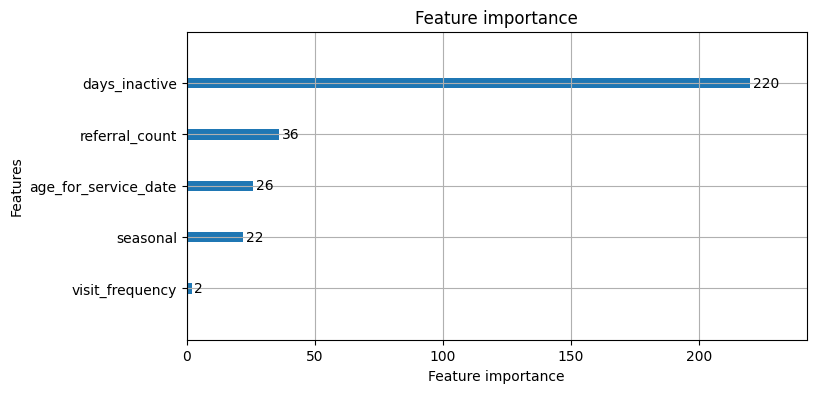

In [67]:
plot_importance(lgb_model, figsize=(8,4))
plt.show()

In [68]:
'''
# Визуализируем значимость переменных
feature_importances = best_model.get_feature_importance(prettified=True)
fig, ax = plt.subplots(figsize=(8,3))
ax.barh( 
    y=feature_importances['Feature Id'],
    width=feature_importances['Importances']
    )
ax.set(
    ylabel='Importance', 
    title=f'Важность признаков на модели CatBoostClassifier'
    )
plt.show()
'''

"\n# Визуализируем значимость переменных\nfeature_importances = best_model.get_feature_importance(prettified=True)\nfig, ax = plt.subplots(figsize=(8,3))\nax.barh( \n    y=feature_importances['Feature Id'],\n    width=feature_importances['Importances']\n    )\nax.set(\n    ylabel='Importance', \n    title=f'Важность признаков на модели CatBoostClassifier'\n    )\nplt.show()\n"

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


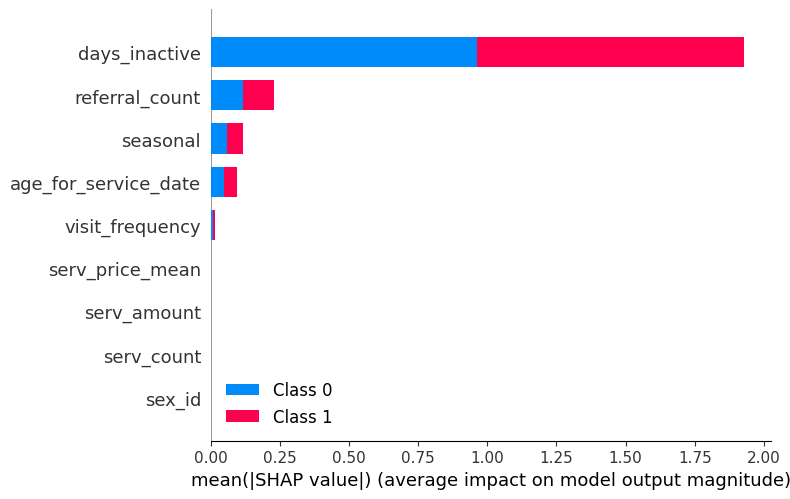

In [69]:
# Визуализируем значимость переменных по векторам Шепли
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_size='auto')

Исходя из построенного графика, можно сделать следующие выводы:
- Наиболее важным признаком для разделяющей способности модели является количество дней с последнего обращения. Чем больше времени прошло с момента последнего обращения, тем менее вероятней человек обратится за помощью.
- Существенную роль также играет количество обращений застрахованного за всё время
- Модель не учитывает количество и сумму оказанных услуг, а также пол застрахованного для определения класса

## Получение результатов

Сформируем новый датасет для получения предсказаний на февраль

In [76]:
data_new = pd.read_csv(
    '/content/drive/MyDrive/datasets/test_assignments/mainslab/MainsLab_data_DS_22.csv',
    parse_dates=[1])

In [77]:
# Обработаем аномалии и удалим пропуски
len_data_new_old = len(data_new)

data_new = data_new.drop_duplicates()

data_new.loc[:,'sex_id'] = data_new.loc[:,'sex_id'].fillna(data_new.groupby('insured')['sex_id'].transform('first'))
data_new = data_new.dropna()

data_new['serv_count'] = data_new['serv_count'].replace(0,1)

temp = data_new.groupby('insured')['sex_id'].nunique()[lambda x: x>1]
data_new = data_new[~data_new['insured'].isin(temp)]

data_new = data_new[data_new['serv_count'] < 500]
data_new = data_new[data_new['serv_amount'] < 150000]
data_new = data_new[data_new['age_for_service_date'] < 100]

print(f'Доля обработанных значений: {len_data_new_old/len(data_new)-1:.3%}')

Доля обработанных значений: 0.025%


In [78]:
# Добавим признаки и сформируем датасет
data_new = make_features(data_new)
df_new = transform_data(data_new)

Получим предсказания, обратится ли застрахованный за помощью в феврале 2022-го года

In [79]:
predictions = pd.Series(best_model.predict(df_new))
predictions_proba = pd.Series(best_model.predict_proba(df_new)[:, 1])

In [80]:
submission_mainslab = pd.concat(
    [predictions_proba, predictions], 
    axis=1).set_index(df_new.index)
submission_mainslab.columns = ['Вероятность обращения', 'Факт обращения']
submission_mainslab

,Вероятность обращения,Факт обращения
insured,,
125045,0.910572,1
125046,0.899756,1
125047,0.295061,0
125048,0.901843,1
125049,0.130614,0
...,...,...
1225822,0.876744,1
1225896,0.843892,1
1225985,0.843892,1


In [81]:
submission_mainslab.to_csv('/content/drive/MyDrive/submission_mainslab_Legoshin_Arseniy.csv')